## KMN Collectives

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kmn_frame = pd.read_excel('data/kmn-v2.xlsx', sheet_name=1)

### The scale of collectives as bubbles by size of group – pairs = 2, family groups = 3-6, ensembles = 6-10 , larger groups = 10+

In [2]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

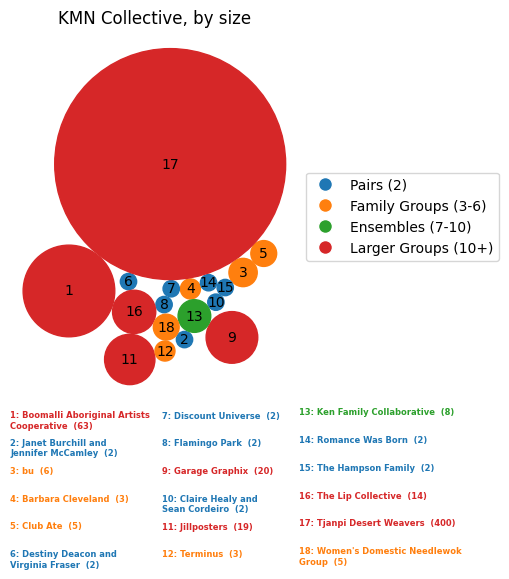

In [3]:
def add_new_lines(s):
    """Insert newlines into a string for better readability."""
    words = s.split(' ')
    new_s = ''
    for i, word in enumerate(words):
        if i % 3 == 0 and i != 0:
            new_s += '\n'
        new_s += word + ' '
    return new_s

collective_sizes = kmn_frame[["Collective Name","size"]].copy()

# pairs = 2, family groups= 3-6, ensembles = 6-10 , larger groups = 10+
collective_sizes["color"] = pd.cut(collective_sizes["size"], bins=[0,2,6,10,500], labels=["tab:blue", "tab:orange", "tab:green", "tab:red"])
collective_sizes["number_ref"] = range(1, len(collective_sizes) + 1)

#ADD YOUR DATA HERE
bubble_data = {
    'categories': collective_sizes["number_ref"],
    'props': collective_sizes["size"],
    'color': collective_sizes["color"]
}
#STEP 3
bubble_chart = BubbleChart(area=bubble_data['props'],
                           bubble_spacing=0.1)
#STEP 4
bubble_chart.collapse()

#STEP 5

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, bubble_data['categories'], bubble_data['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title("KMN Collective, by size")

# add legend
legend_labels = ['Pairs (2)', 'Family Groups (3-6)', 'Ensembles (7-10)', 'Larger Groups (10+)']
legend_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]

# outside of the plot
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

# lets add annotations in three lists of six
for i, row in collective_sizes.iterrows():
    name_and_size = f"{row["number_ref"]}: {add_new_lines(row["Collective Name"])} ({row["size"]})"
    name_and_size_color = row["color"]
    if i < 6:
        ax.annotate(f"{name_and_size}", (0, 0.05), (0, -20 - 20*i), xycoords='axes fraction', textcoords='offset points', va='top', ha='left', fontsize=6, color=name_and_size_color, fontweight='bold')
    elif i < 12:
        ax.annotate(f"{name_and_size}", (0.525, 0.5), (0, -20 - 20*i), xycoords='axes fraction', textcoords='offset points', va='top', ha='left', fontsize=6, color=name_and_size_color, fontweight='bold')
    else:
        ax.annotate(f"{name_and_size}", (1, 0.96), (0, -20 - 20*i), xycoords='axes fraction', textcoords='offset points', va='top', ha='left', fontsize=6, color=name_and_size_color, fontweight='bold')

plt.show()

### Fields of production   =. craft (textiles), fashion, graphic design (prints), publication, mixed media (including performance);

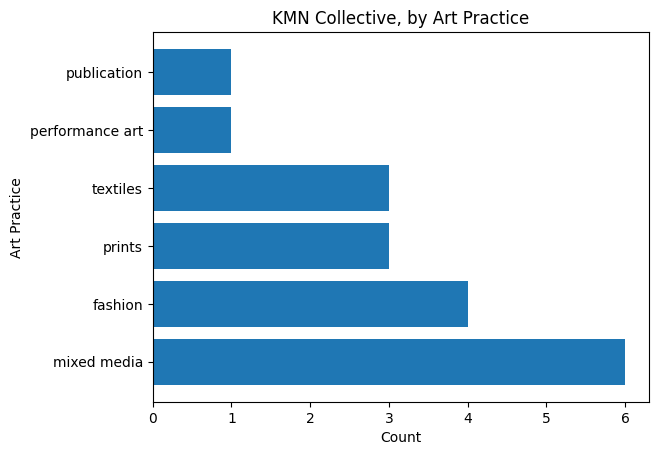

In [4]:
kmn_frame["art practice2"] = np.where(kmn_frame["art practice"].str.contains("craft"), "textiles", kmn_frame["art practice"])
kmn_frame["art practice2"] = np.where(kmn_frame["art practice2"].str.contains("journal"), "publication", kmn_frame["art practice2"])

# bar chart
art_practice_counts = kmn_frame["art practice2"].value_counts()
art_practice_counts = art_practice_counts.reset_index()
art_practice_counts.columns = ["art practice", "count"]
art_practice_counts = art_practice_counts.sort_values("count", ascending=False)

fig, ax = plt.subplots()
ax.barh(art_practice_counts["art practice"], art_practice_counts["count"], color="tab:blue")
ax.set_xlabel("Count")
ax.set_ylabel("Art Practice")
ax.set_title("KMN Collective, by Art Practice")
plt.show()

/var/folders/gm/qd1sm1x551zf2qwxk06w8wpw0000gn/T/ipykernel_48721/792596695.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  collective_sizes_practices_pivot = collective_sizes_practices.pivot_table(index='size_group', columns='art practice2', values='Collective Name', aggfunc='count')


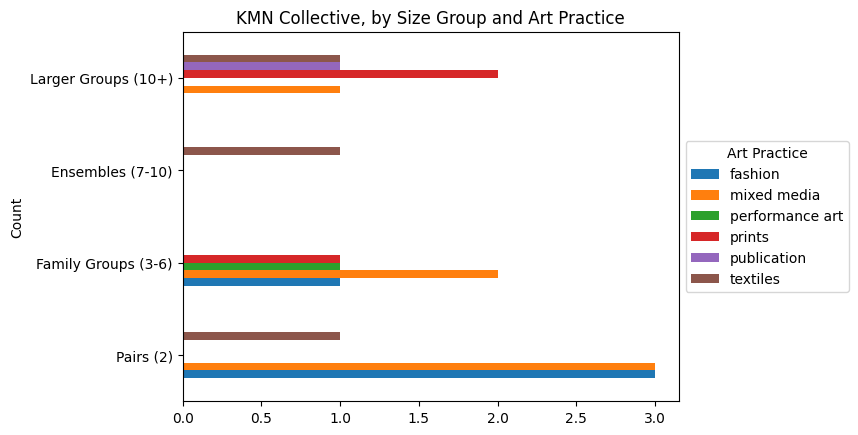

In [5]:
# clustered bar chart using collective_sizes_practices, with size_group as the x-axis and art practice as the hue
# do not do stacked bar chart, must be clustered
collective_sizes["size_group"] = pd.cut(collective_sizes["size"], bins=[0,2,6,10,500], labels=['Pairs (2)', 'Family Groups (3-6)', 'Ensembles (7-10)', 'Larger Groups (10+)'])
collective_sizes_practices = pd.merge(collective_sizes, kmn_frame[['Collective Name','art practice2']], on='Collective Name', how='left')

# create a pivot table
collective_sizes_practices_pivot = collective_sizes_practices.pivot_table(index='size_group', columns='art practice2', values='Collective Name', aggfunc='count')
collective_sizes_practices_pivot = collective_sizes_practices_pivot.fillna(0)
collective_sizes_practices_pivot

# plot the clustered bar chart
fig, ax = plt.subplots()
collective_sizes_practices_pivot.plot(kind='barh', stacked=False, ax=ax)
ax.set_ylabel("Count")
ax.set_title("KMN Collective, by Size Group and Art Practice")

# move legend outside of the plot
ax.legend(title='Art Practice', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Map of longitide and latitiude according to Collective sheet
- *Note: Some data had missing geocodes*.

In [6]:
import plotly.express as px
import pandas as pd

# Create a numeric representation of size groups for the scatter plot
size_mapping = {
    'Pairs (2)': 5, 
    'Family Groups (3-6)': 10, 
    'Ensembles (7-10)': 20, 
    'Larger Groups (10+)': 30
}
kmn_frame["size_label"] = pd.cut(kmn_frame["size"], bins=[0,2,6,10,500], labels=['Pairs (2)', 'Family Groups (3-6)', 'Ensembles (7-10)', 'Larger Groups (10+)'])
kmn_frame["size_value"] = kmn_frame["size_label"].map(size_mapping)

# Clean latitude data if needed
collective_long_lat = kmn_frame[["Collective Name", "longitude", "latitude","size_label","size_value"]].copy() 

# there is one row which has two values in the latitude column, lets keep only the first one
collective_long_lat["latitude"] = collective_long_lat["latitude"].apply(lambda x: x[:11] if isinstance(x, str) else x)

# Convert longitude and latitude to numeric values
collective_long_lat["longitude"] = pd.to_numeric(collective_long_lat["longitude"], errors='coerce')
collective_long_lat["latitude"] = pd.to_numeric(collective_long_lat["latitude"], errors='coerce')

# Drop rows with NaN values
collective_long_lat = collective_long_lat.dropna()

# Looking at your data, it seems longitude and latitude might be swapped in some rows
# Let's fix that by ensuring latitude is between -90 and 90, and longitude is between -180 and 180
for i, row in collective_long_lat.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    
    # If latitude is outside valid range but longitude would be valid as latitude
    if abs(lat) > 90 and abs(lon) <= 90:
        collective_long_lat.at[i, 'latitude'] = lon
        collective_long_lat.at[i, 'longitude'] = lat

# Create the map
px.set_mapbox_access_token("pk.eyJ1Ijoia2FiaXJtYW5hbmRoYXIiLCJhIjoiY2w3ZTMxYWxpMDNtajN3bHZvbHJyYThueiJ9.DpnmOuQdHCWU_crpaEZqAg")

# Use color_discrete_sequence instead of color_continuous_scale since "Collective Name" is categorical
fig = px.scatter_mapbox(
    collective_long_lat, 
    lat="latitude", 
    lon="longitude", 
    color="Collective Name", 
    hover_name="Collective Name",
    hover_data={
        "size_label": True,      # Show size_label
        "size_value": False,     # Hide size_value
        "latitude": False,       # Hide latitude 
        "longitude": False       # Hide longitude
    },
    zoom=3,  # Reduced zoom to see all points
    height=720,
    width=1440,
    size = "size_value",
    size_max=30
)

fig.update_layout(mapbox_style="light")
fig.show()

In [7]:
fig.write_html("kmn_collective_birth_map.html")

### Plotting foundation and cessation years for each collective over time
- *Note: Some collectives had missing data*.

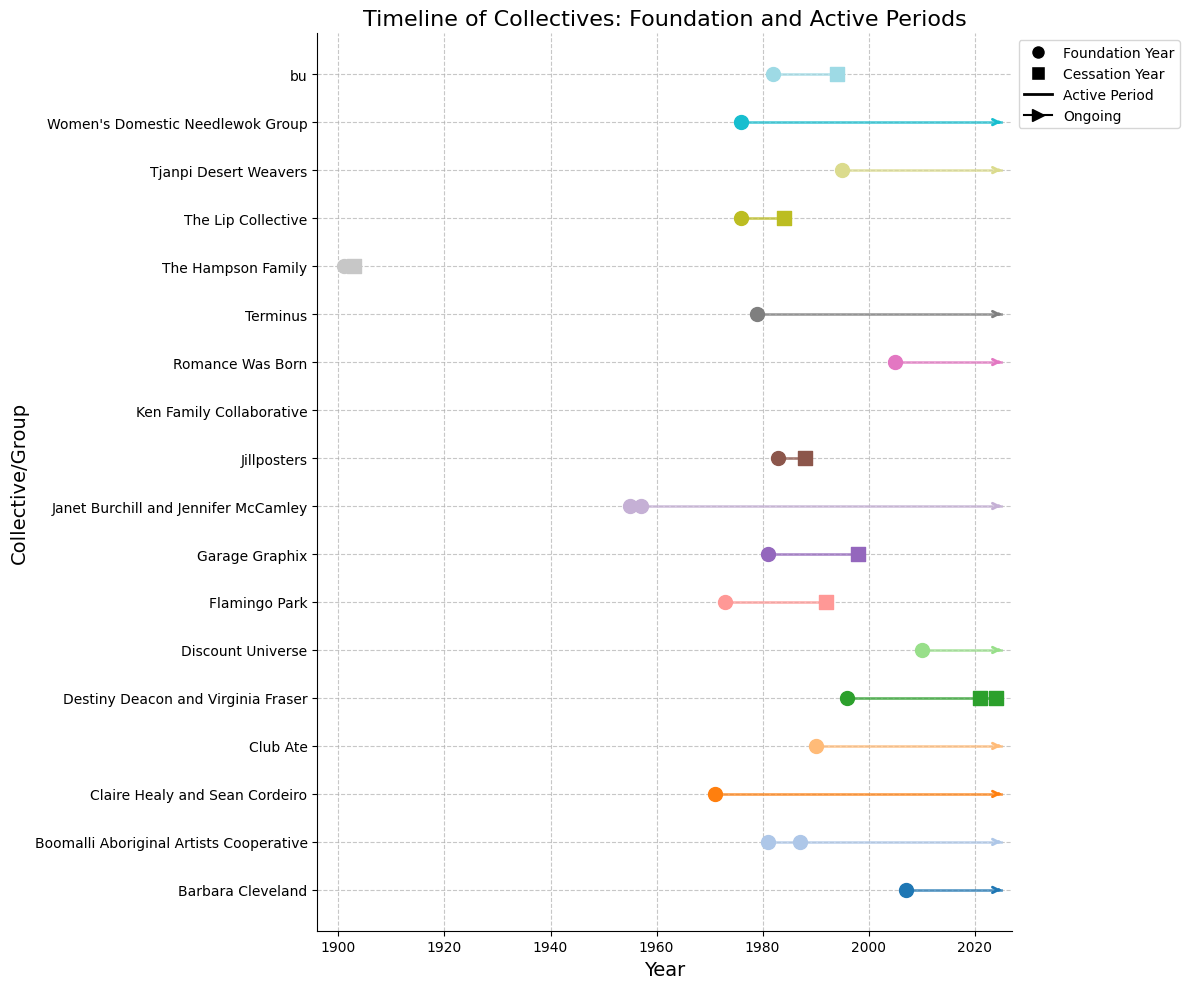

In [404]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

foundation_year = {}
cessation_year = {}
for idx, row in kmn_frame.iterrows():
    kmn_name = row["Collective Name"]
    foundation_year[kmn_name] = []
    cessation_year[kmn_name] = []
    if isinstance(row["foundation year"], str):
        foundation_yr1 = int(row["foundation year"][:4])
        foundation_yr2 = int(row["foundation year"][-4:])
        foundation_year[kmn_name].append(foundation_yr1)
        foundation_year[kmn_name].append(foundation_yr2)
    else:
        foundation_year[kmn_name].append(row["foundation year"])

    if isinstance(row["date of death/ending"], str):
        if row["date of death/ending"] == 'N/A (Still Living)':
            cessation_year[kmn_name].append(2025)
        else:
            cessation_yr1 = int(row["date of death/ending"][:4])
            cessation_yr2 = int(row["date of death/ending"][-4:])
            cessation_year[kmn_name].append(cessation_yr1)
            cessation_year[kmn_name].append(cessation_yr2)
    else:
        cessation_year[kmn_name].append(row["date of death/ending"])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique groups and sort them
groups = sorted(foundation_year.keys())
y_positions = range(len(groups))

# Create colormap for different groups
colors = plt.cm.tab20(np.linspace(0, 1, len(groups)))

# Set the current year (end of x-axis)
current_year = 2025

# Plot each group
for i, group in enumerate(groups):
    # Foundation years (start points)
    start_years = foundation_year[group]
    if not isinstance(start_years, list):
        start_years = [start_years]
    
    # Filter out nan values
    start_years = [year for year in start_years if not pd.isna(year)]
    
    # Cessation years (end points)
    end_years = cessation_year[group]
    if not isinstance(end_years, list):
        end_years = [end_years]
    
    # Check if this is an ongoing group (cessation year is 2025)
    is_ongoing = all(year == current_year for year in end_years)
    
    # Filter out current_year values for ongoing groups
    if is_ongoing:
        plot_end_years = []
    else:
        plot_end_years = end_years
    
    # Plot start years
    if start_years:
        ax.scatter(start_years, [i] * len(start_years), color=colors[i], s=100, zorder=3, label=group if i == 0 else "")
    
    # Plot end years (only for non-ongoing groups)
    if plot_end_years:
        ax.scatter(plot_end_years, [i] * len(plot_end_years), color=colors[i], s=100, marker='s', zorder=3)
    
    # Draw line connecting earliest foundation to latest cessation or current year if ongoing
    if start_years:
        earliest_start = min(start_years)
        if is_ongoing:
            # For ongoing groups, extend line to current year
            latest_end = current_year
            # Add arrow at the end for ongoing groups
            ax.annotate('', xy=(latest_end, i), xytext=(latest_end-1, i),
                     arrowprops=dict(arrowstyle='->', color=colors[i], lw=2))
        else:
            latest_end = max(end_years)
        
        # Draw the line
        ax.plot([earliest_start, latest_end], [i, i], color=colors[i], linewidth=2, alpha=0.7, zorder=2)

# Set y-axis tick labels
ax.set_yticks(y_positions)
ax.set_yticklabels(groups)

# Set x-axis limits with some padding
all_years = []
for group in groups:
    if foundation_year[group] and not all(pd.isna(year) for year in foundation_year[group] if isinstance(foundation_year[group], list)):
        all_years.extend([year for year in foundation_year[group] if not pd.isna(year)])
    
    # Include only non-2025 cessation years for calculating range
    ces_years = [year for year in cessation_year[group] if not pd.isna(year) and year != current_year]
    if ces_years:
        all_years.extend(ces_years)

min_year = min(all_years) - 5
max_year = current_year + 2  # Add a bit of space after current year
ax.set_xlim(min_year, max_year)

# Format the plot
ax.grid(True, linestyle='--', alpha=0.7, zorder=1)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add title and labels
plt.title('Timeline of Collectives: Foundation and Active Periods', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Collective/Group', fontsize=14)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Foundation Year'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, label='Cessation Year'),
    plt.Line2D([0], [0], color='black', lw=2, label='Active Period'),
    plt.Line2D([0], [0], marker='>', color='black', markersize=8, label='Ongoing')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [8]:
collective_individuals_dict = {}
for idx, name in enumerate(kmn_frame["Artist Names (if known)"]):
    if pd.isna(name):
        collective_individuals_dict[kmn_frame["Collective Name"][idx]] = []
    else:
        names = name.replace(" and Anne\nSheridan",", Anne Sheridan")\
            .replace("Zana\nDare","Zana Dare")\
            .replace("Kate\nReeves","Kate Reeves")\
            .replace(" and Minerva",", Minerva")\
            .replace("\n",", ")\
            .replace("Todd Fernando and","Todd Fernando, ")\
            .replace("and Karen","Karen")
        if names[-1] == ".": names = names[:-1]
        collective_individuals_dict[kmn_frame["Collective Name"][idx]] = [
            n.replace(" (dec.)", "").replace("and two men: ","").strip() for n in names.split(", ")
        ]

# create rows foreach key and value pair
rows = []
for key, value in collective_individuals_dict.items():
    for v in value:
        rows.append([key, v])

# create a dataframe
individuals_df = pd.DataFrame(rows, columns=["Collective Name", "Individual Name"])
individuals_df

,Collective Name,Individual Name
0,Boomalli Aboriginal Artists Cooperative,Euphemia Bostock
1,Boomalli Aboriginal Artists Cooperative,Fiona Foley
2,Boomalli Aboriginal Artists Cooperative,Michael Riley
3,Boomalli Aboriginal Artists Cooperative,Tracey Moffatt
4,Boomalli Aboriginal Artists Cooperative,Jeffrey Samuels
...,...,...
105,Women's Domestic Needlewok Group,Marie McMahon
106,Women's Domestic Needlewok Group,Frances (Budden) Phoenix
107,Women's Domestic Needlewok Group,Jan Fieldsend
108,Women's Domestic Needlewok Group,Marla Guppy


### Investigating individual trajectories w.r.t the collective formation/cessation
- We first identify all individuals (according to Collective sheet in KMN) who are in the DAAO
- Matches are determined by matching DAAO display name. This may lead to some mismatches.
- For each DAAO match, we gather all available time-based data i.e., birth, death, career start dates, career end dates, education start and end dates, and exhibition dates.

In [9]:
# for data mgmt
import pandas as pd

acde_people = pd.read_csv('data/acde_person.csv')
daao_people = acde_people[acde_people.data_source.str.contains('DAAO')].copy()
del acde_people

/var/folders/gm/qd1sm1x551zf2qwxk06w8wpw0000gn/T/ipykernel_48721/4264281361.py:4: DtypeWarning:

Columns (4,5,9,11,12,14,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,51,52,53,54,55,56,57,58,59,60,61,63,66) have mixed types. Specify dtype option on import or set low_memory=False.



In [10]:
import json
daao_people.display_name = daao_people.display_name.str.replace('"', '')

collective_individuals_daao = pd.merge(individuals_df, daao_people, left_on="Individual Name", right_on="display_name", how="left")
collective_individuals_daao.columns

collective_individuals_daao = collective_individuals_daao[[
    "Collective Name", "Individual Name", "ori_dbid", "birth", "death","career","education_trainings", "related_events"
]].copy()

# duplicates = collective_individuals_daao[collective_individuals_daao.ori_dbid.notnull()]["Individual Name"].value_counts().reset_index().head(6)["Individual Name"].values
duplicates = ["Michael Riley","Jan Mackay","Lesley Dumbrell","Jan Fieldsend"]
duplicates_idx = collective_individuals_daao[(collective_individuals_daao["Individual Name"].isin(duplicates)) & (collective_individuals_daao.birth.isnull())].index

# remove duplicates by idx
collective_individuals_daao.drop(duplicates_idx, inplace=True)

In [11]:
birth_data = {}
death_data = {}
career_start_year_data = {}
career_end_year_data = {}
career_data_frame = pd.DataFrame()
education_start_year_data = {}
education_end_year_data = {}
education_data_frame = pd.DataFrame()
event_year_data = {}
event_data_frame = pd.DataFrame()

for idx, row in collective_individuals_daao.iterrows():
    birth_data[row["Individual Name"]] = []
    death_data[row["Individual Name"]] = []
    career_start_year_data[row["Individual Name"]] = []
    career_end_year_data[row["Individual Name"]] = []
    education_start_year_data[row["Individual Name"]] = []
    education_end_year_data[row["Individual Name"]] = []
    event_year_data[row["Individual Name"]] = []

    if pd.isnull(row["birth"]):
        pass
    else:
        birth = json.loads(row["birth"])
        birth_data[row["Individual Name"]].append(int(pd.json_normalize(birth)["coverage.date.year"].values[0]))

    if pd.isnull(row["death"]):
        pass
    else:
        death = json.loads(row["death"])
        death_data[row["Individual Name"]].append(int(pd.json_normalize(death)["coverage.date.year"].values[0]))
    
    if pd.isnull(row["career"]):
        pass
    else:
        career = json.loads(row["career"])
        career_data = pd.json_normalize(career["career_periods"])
        career_data["Individual Name"] = row["Individual Name"]
        career_data_frame = pd.concat([career_data_frame, career_data])

        if "coverage_range.date_range.date_start.year" in career_data.columns:
            career_start_year_data[row["Individual Name"]].extend(career_data["coverage_range.date_range.date_start.year"].dropna().astype(int).unique())

        if "coverage_range.date_range.date_end.year" in career_data.columns:
            career_end_year_data[row["Individual Name"]].extend(career_data["coverage_range.date_range.date_end.year"].dropna().astype(int).unique())

    if pd.isnull(row["education_trainings"]):
        pass
    else:
        education = json.loads(row["education_trainings"])
        education_data = pd.json_normalize(education)
        education_data["Individual Name"] = row["Individual Name"]
        education_data_frame = pd.concat([education_data_frame, education_data])

        if "organization.coverage.date_range.date_start.year" in education_data.columns:
            education_start_year_data[row["Individual Name"]].extend(education_data["organization.coverage.date_range.date_start.year"].dropna().astype(int).unique())

        if "organization.coverage.date_range.date_end.year" in education_data.columns:
            education_end_year_data[row["Individual Name"]].extend(education_data["organization.coverage.date_range.date_end.year"].dropna().astype(int).unique())

    if pd.isnull(row["related_events"]):
        pass
    else:
        events = json.loads(row["related_events"])
        events_data = pd.json_normalize(events)
        events_data["Individual Name"] = row["Individual Name"]
        event_data_frame = pd.concat([event_data_frame, events_data])

        for edx, event in pd.json_normalize(events).iterrows():
            try:
                event_year_data[row["Individual Name"]].append(int(pd.json_normalize(event["object.coverage_ranges"])["date_range.date_start.year"].values[0]))
            except:
                pass

# Create the DataFrame
merged_dicts = pd.DataFrame({
    'birth_year': birth_data,
    'death_year': death_data,
    'career_start_year': career_start_year_data,
    'career_end_year': career_end_year_data,
    'education_start_year': education_start_year_data,
    'education_end_year': education_end_year_data,
    'event_year': event_year_data
})

# If you need to reset the index to make the keys a column instead
merged_dicts = merged_dicts.reset_index().rename(columns={'index': 'entity_id'})

collective_individuals_daao_data = pd.merge(collective_individuals_daao[['Collective Name', 'Individual Name']], merged_dicts, left_on='Individual Name', right_on='entity_id', how='left')

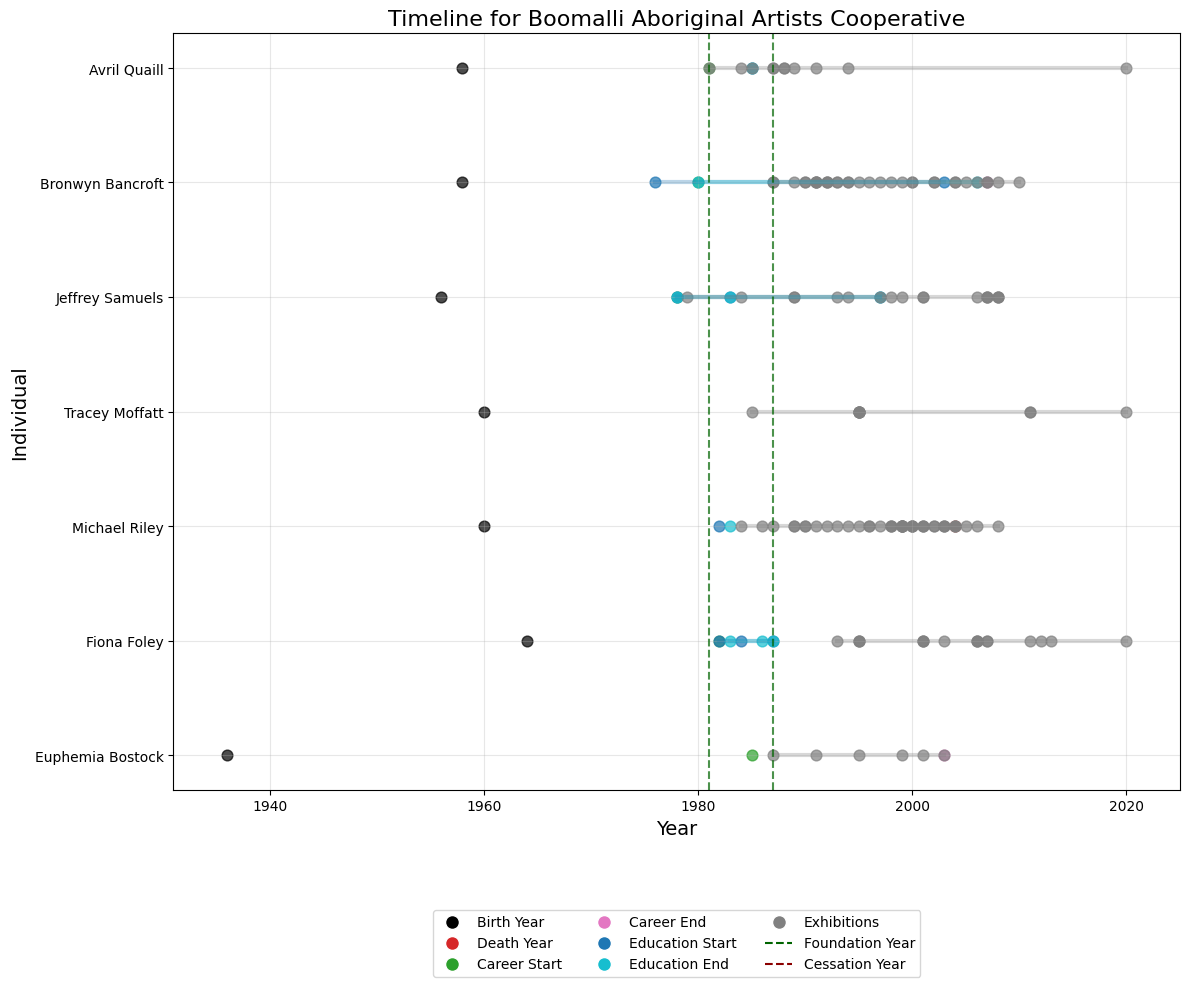

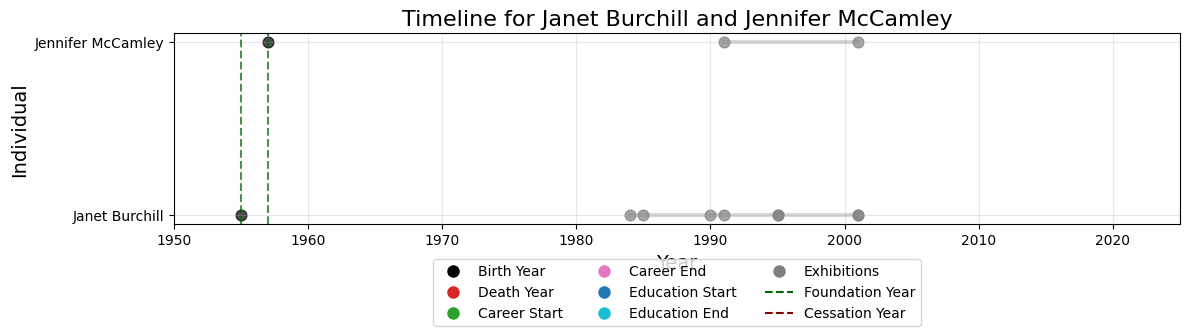

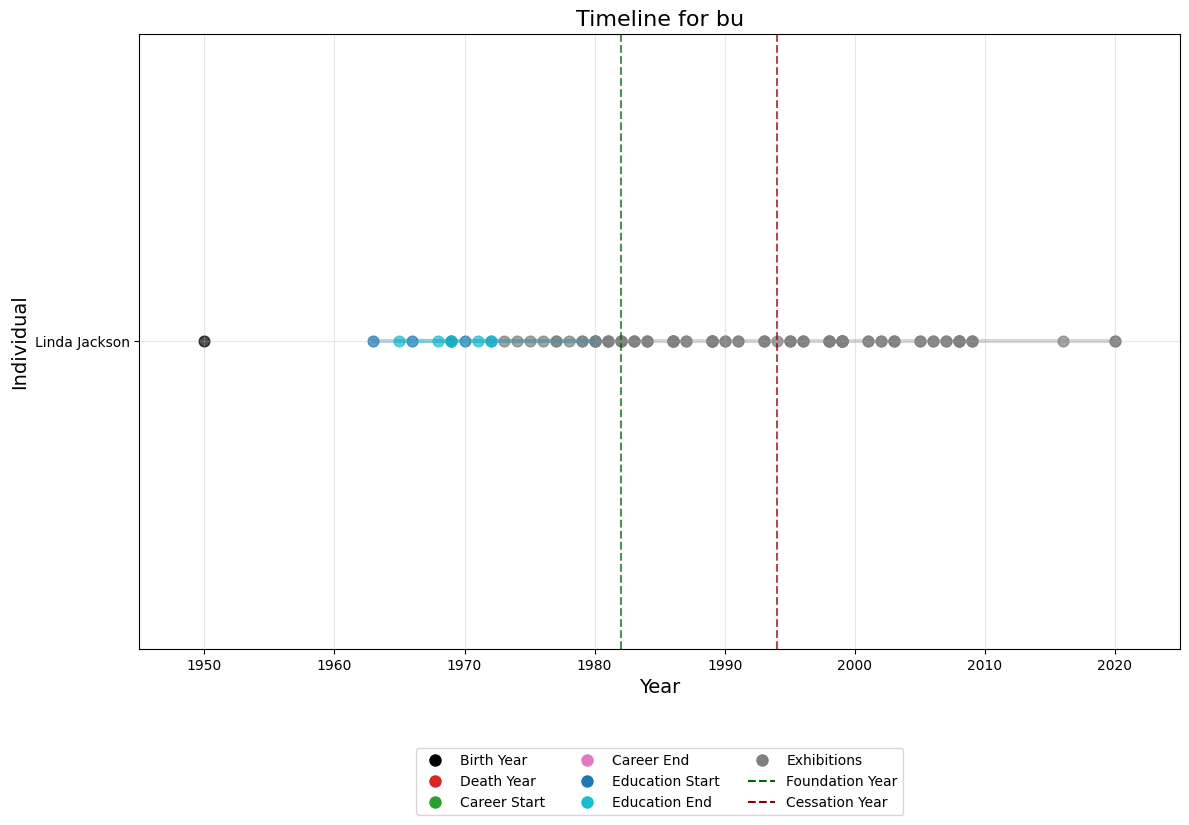

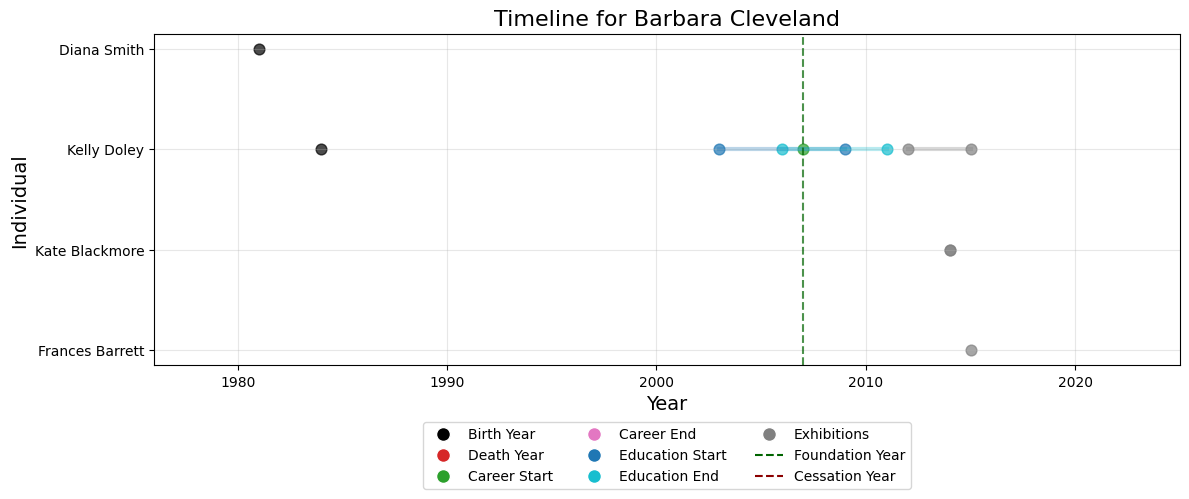

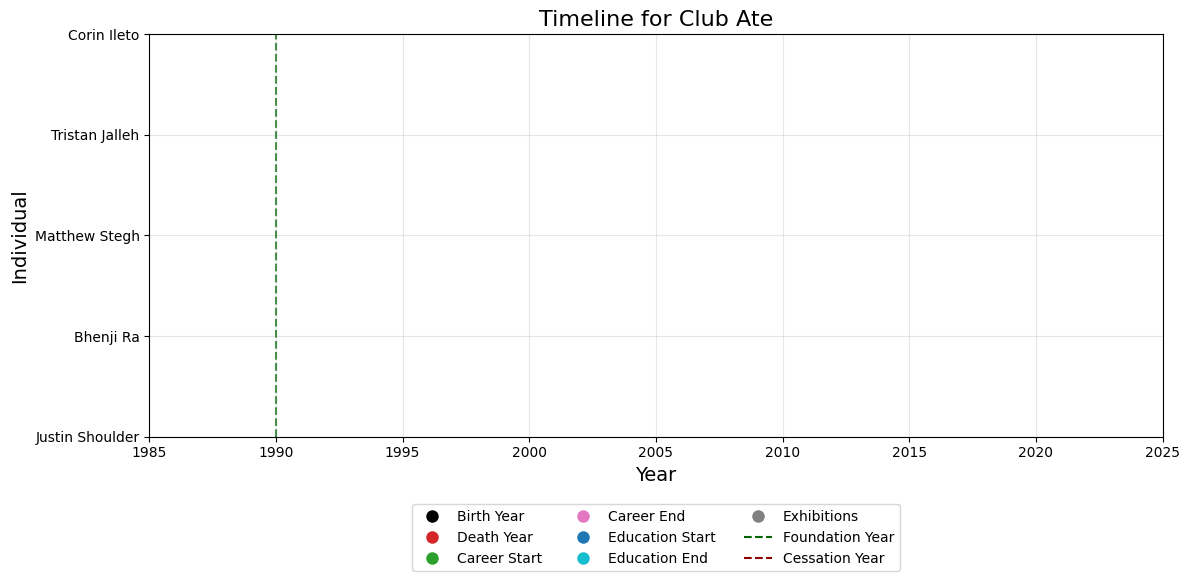

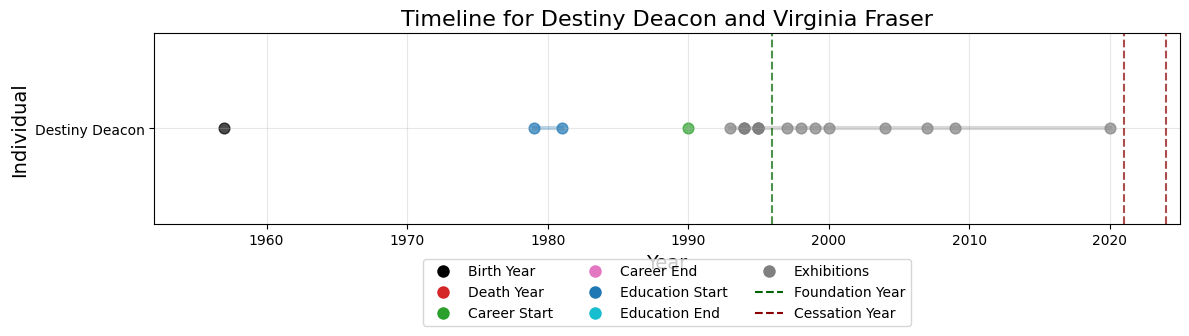

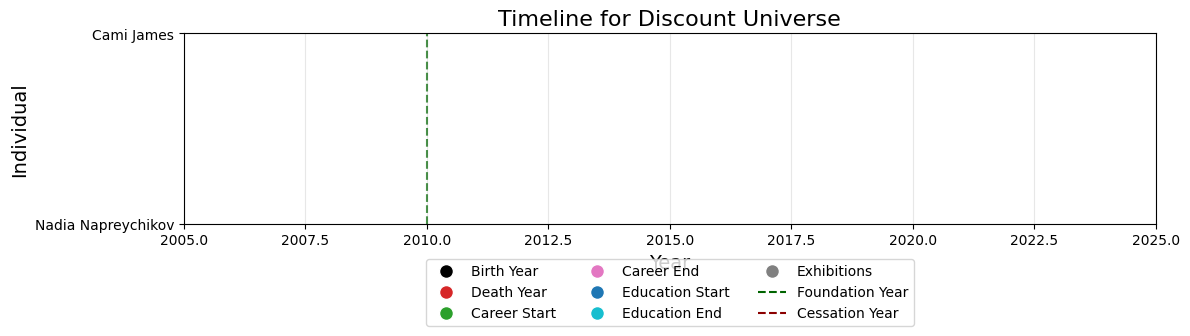

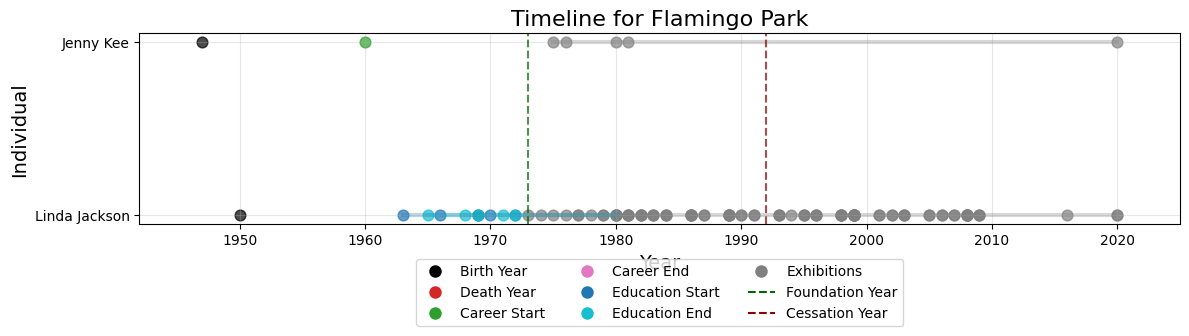

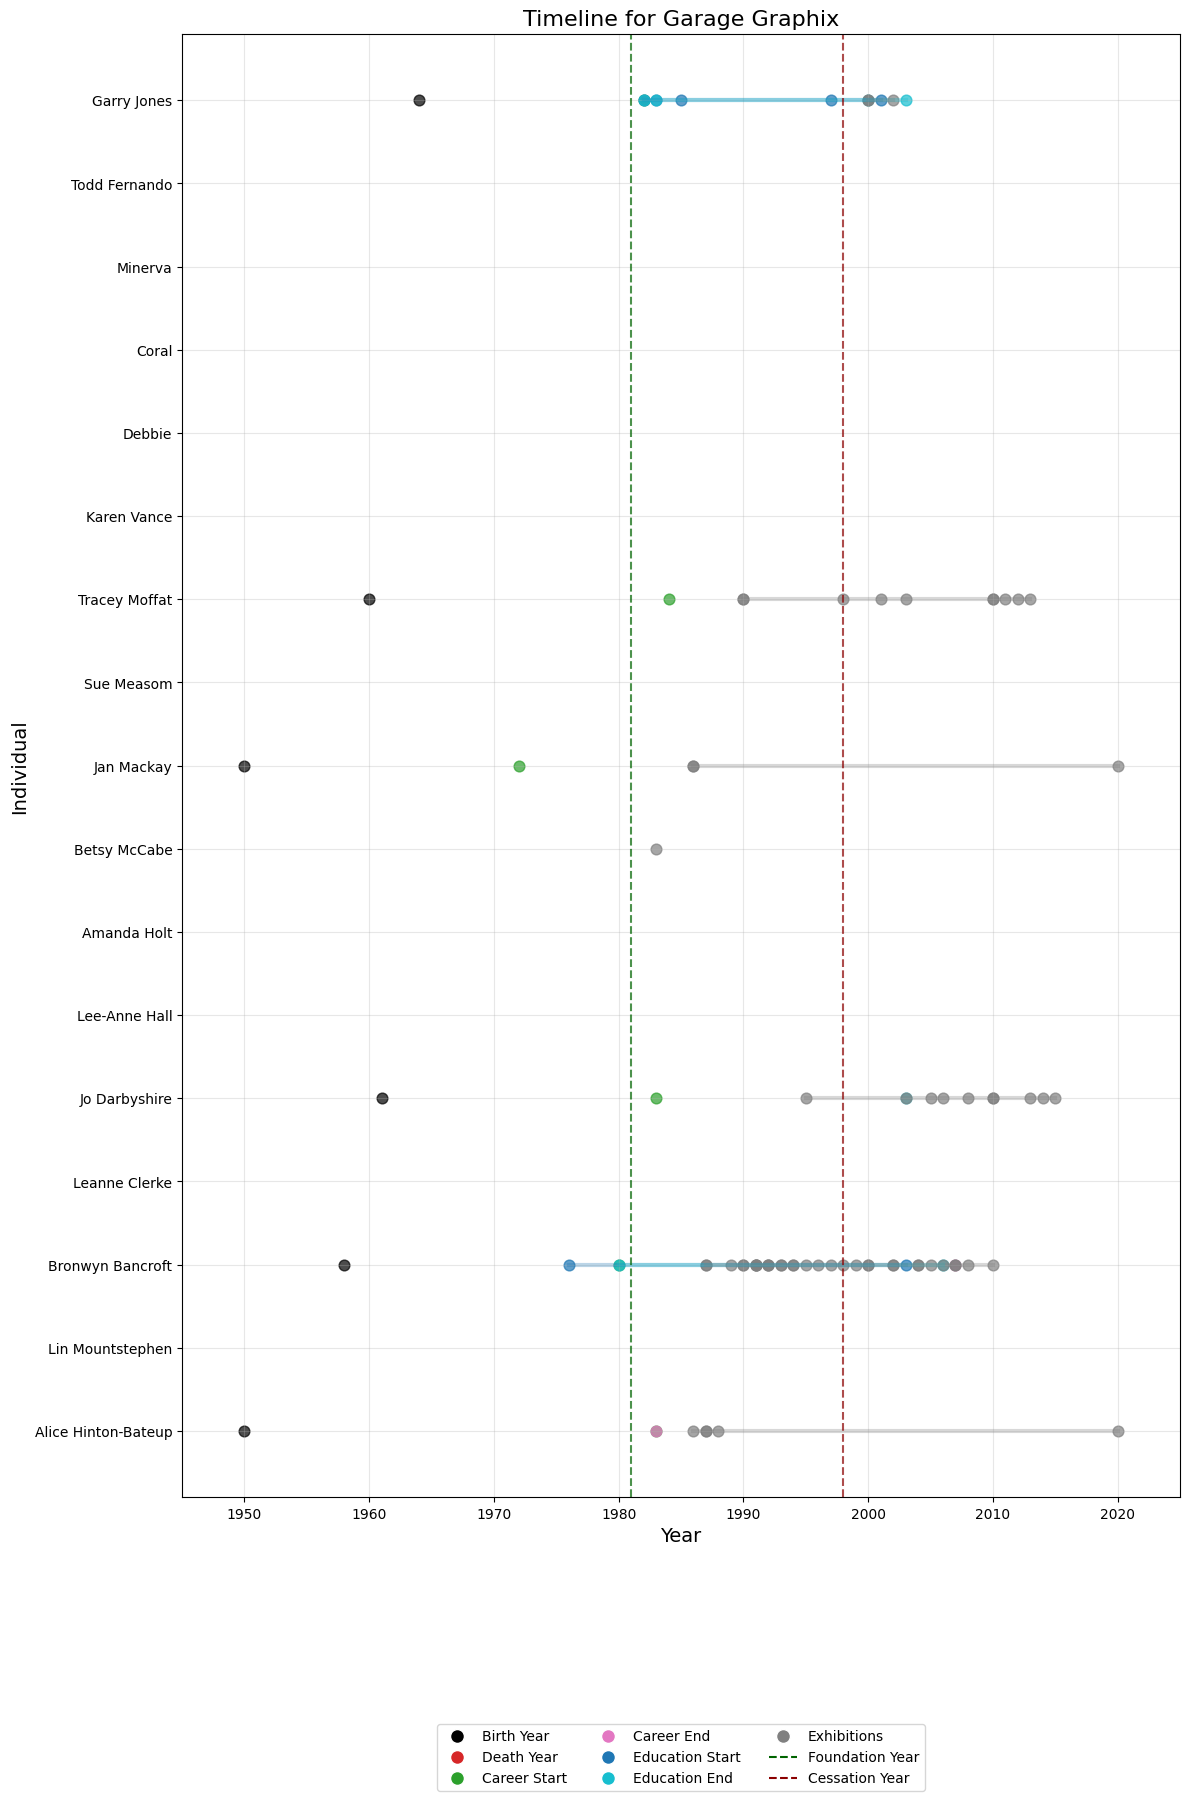

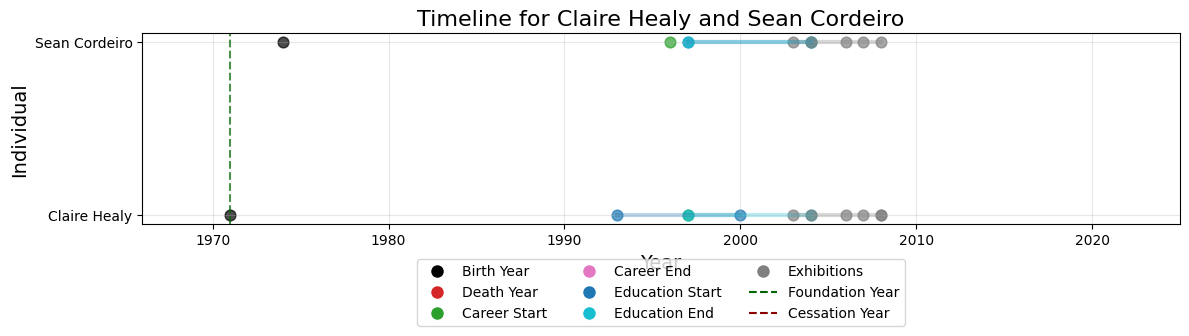

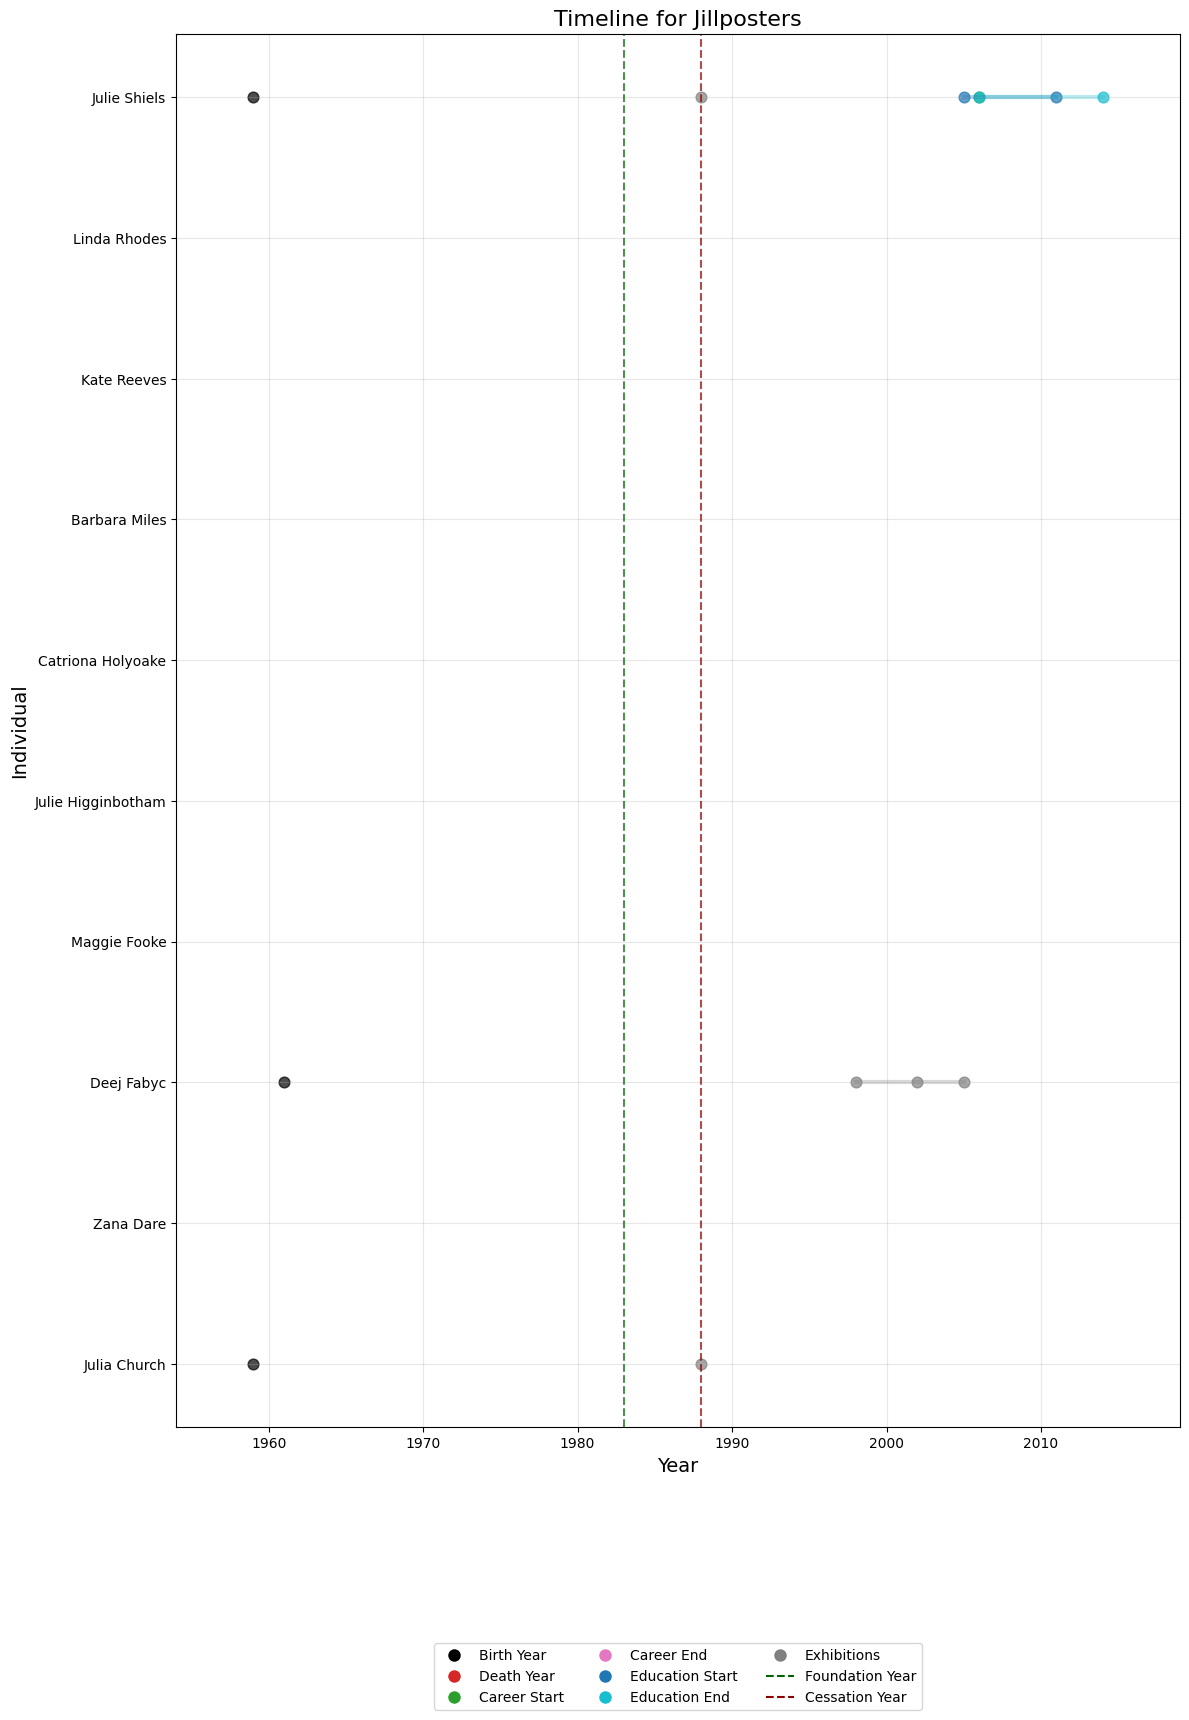

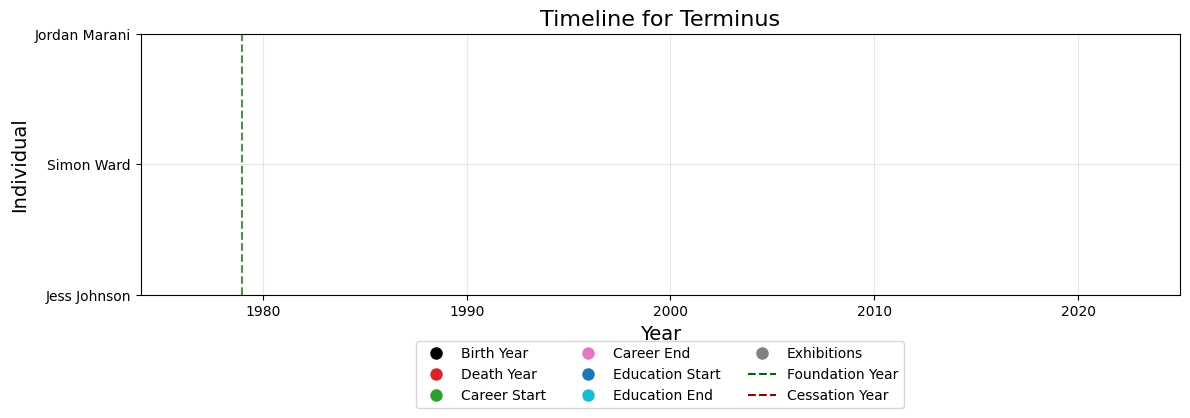

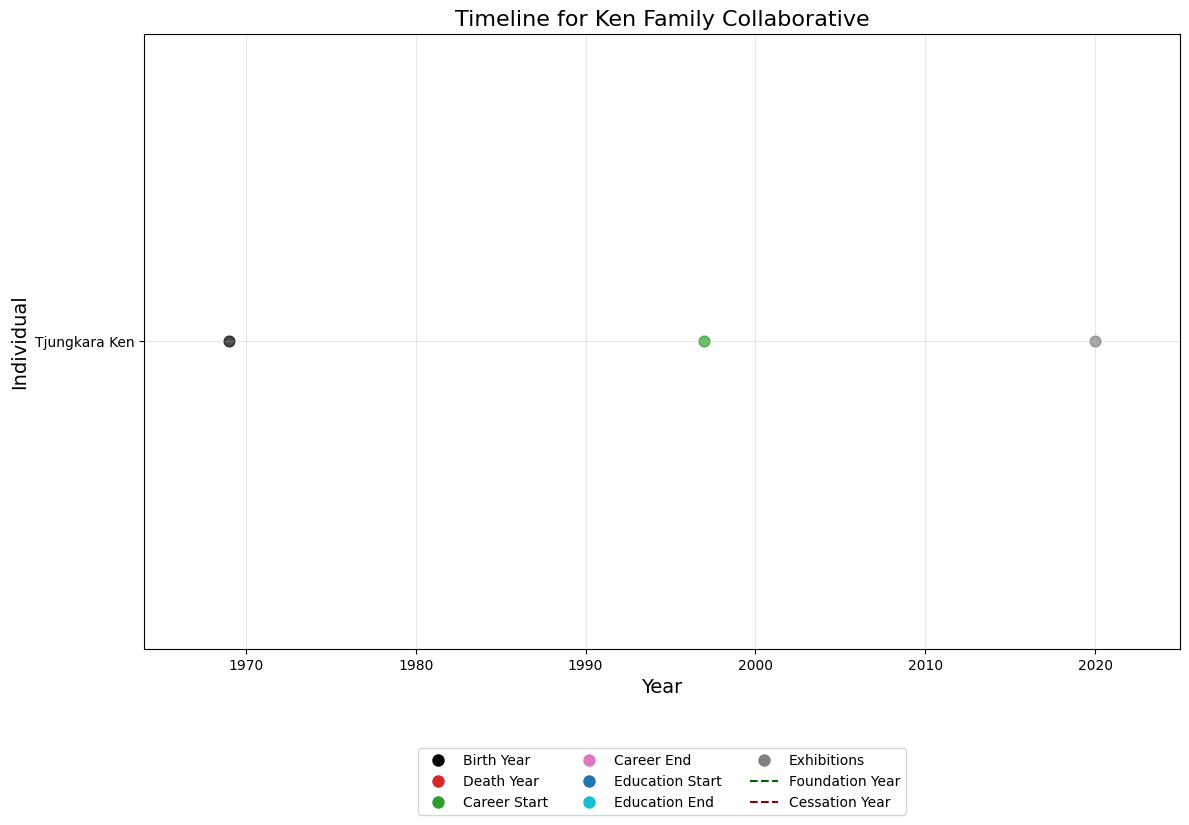

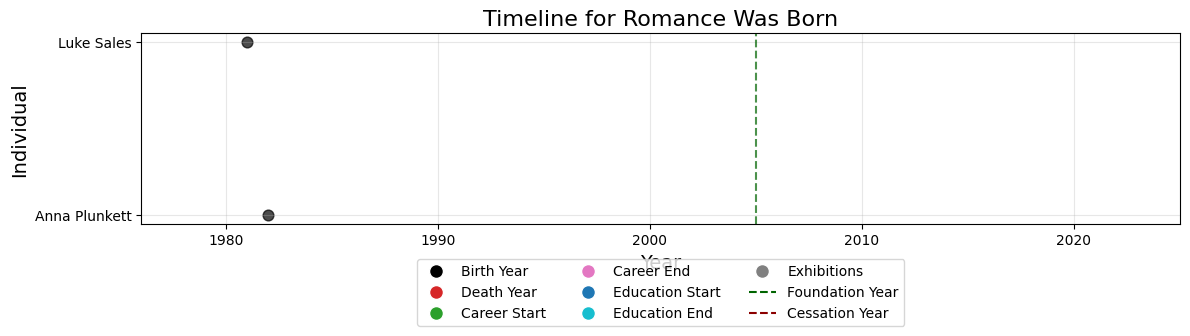

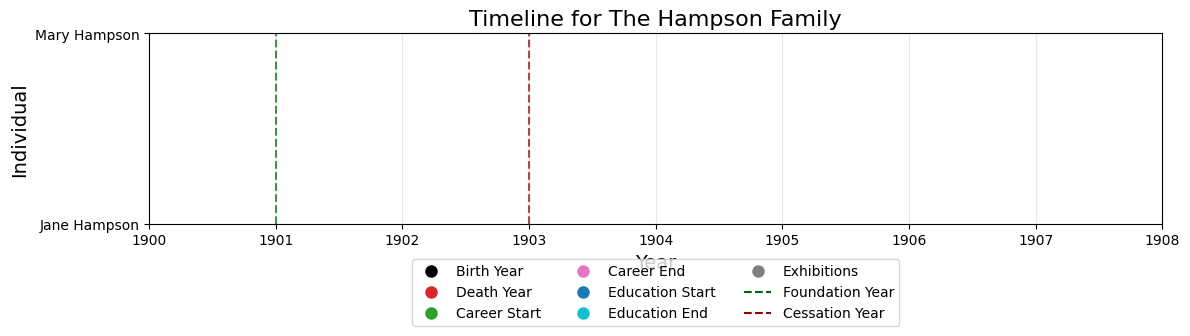

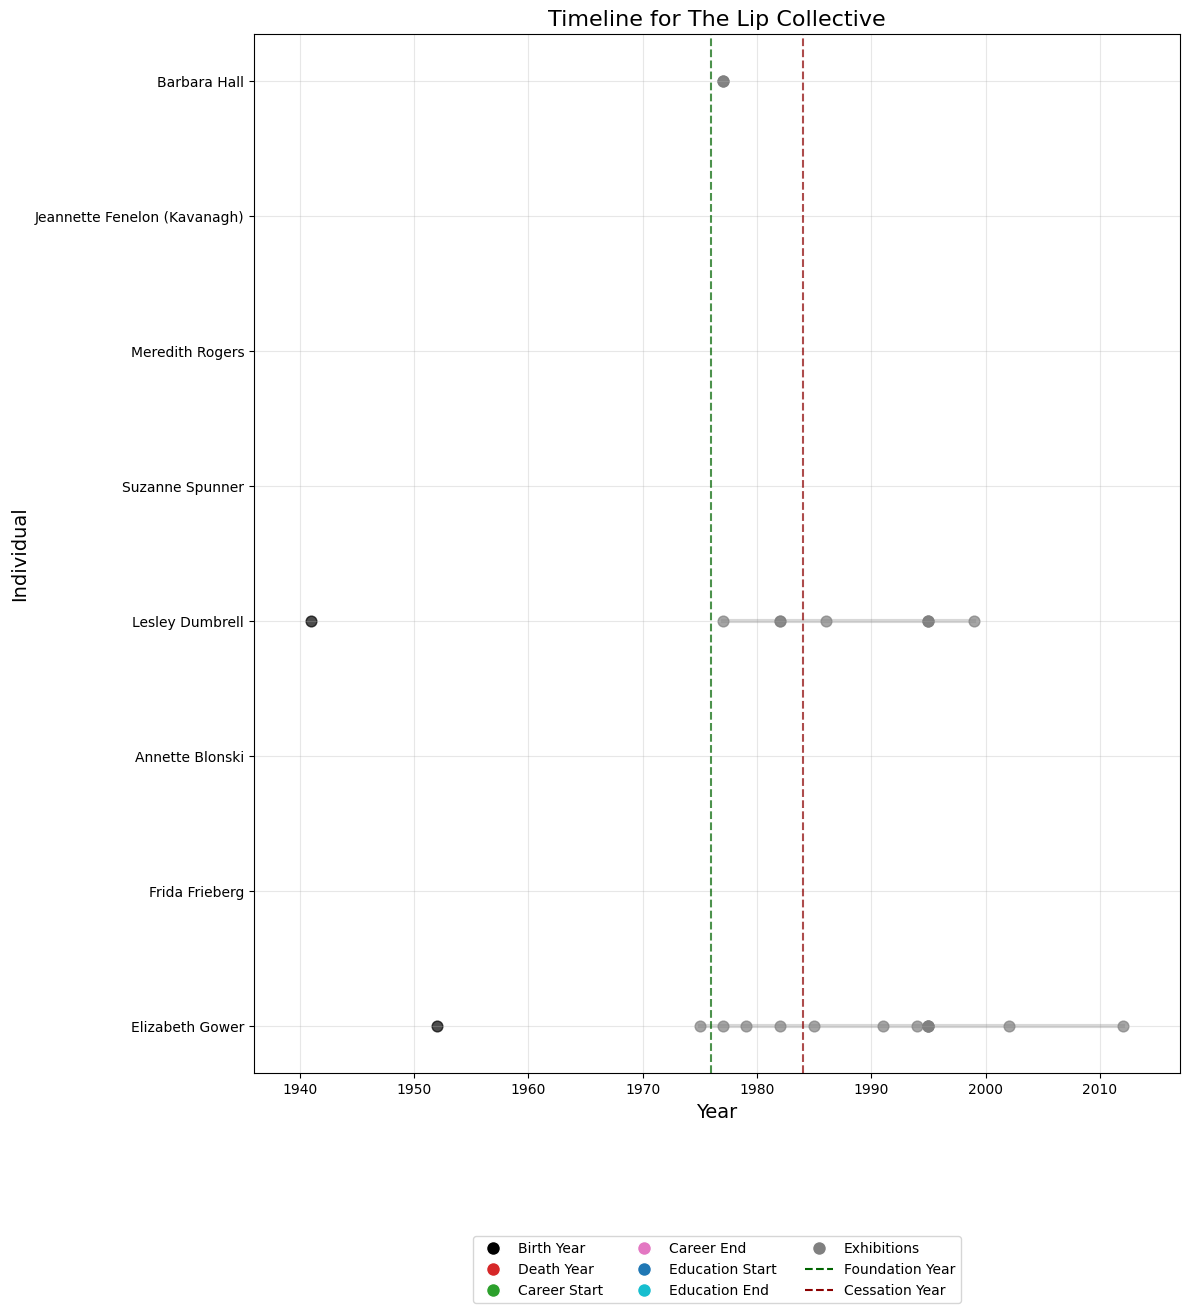

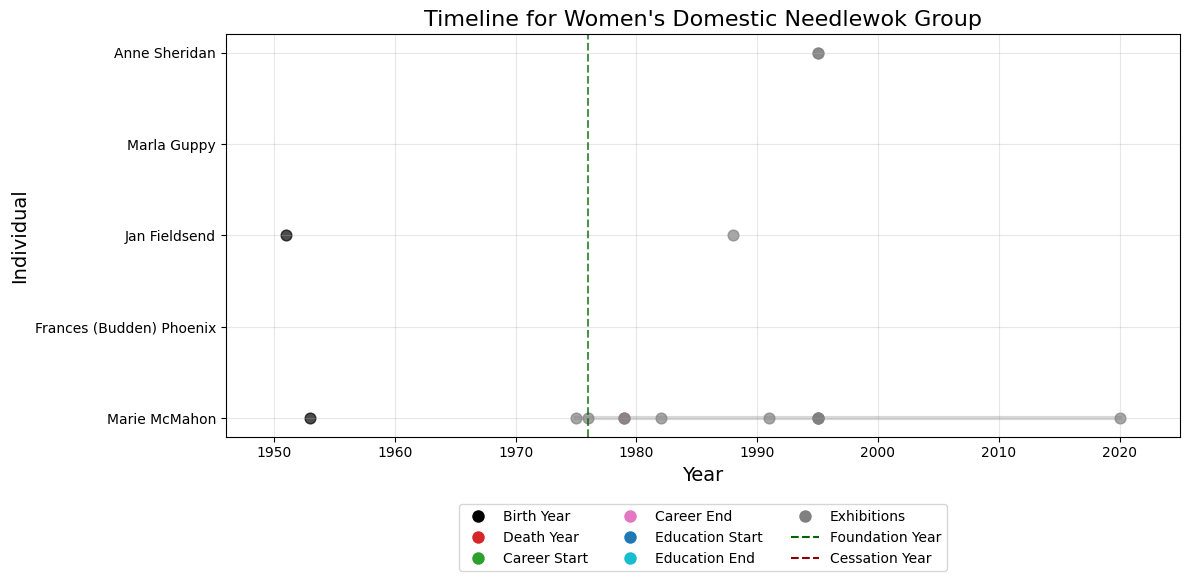

In [411]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define color mapping for different event types
color_mapping = {
    'birth_year': 'black',
    'death_year': 'tab:red',
    'career_start_year': 'tab:green',
    'career_end_year': 'tab:pink',
    'education_start_year': 'tab:blue',
    'education_end_year': 'tab:cyan',
    'event_year': 'grey',
    'foundation_year': 'darkgreen',
    'cessation_year': 'darkred'
}

# Create a function to plot timeline for a single collective
def plot_collective_timeline(collective_name, df, foundation_years, cessation_years):
    # Filter data for the specific collective
    collective_data = df[df['Collective Name'] == collective_name].copy()
    
    if len(collective_data) == 0:
        print(f"No data available for {collective_name}")
        return
    
    # Get unique individuals in the collective
    individuals = collective_data['Individual Name'].unique()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, len(individuals)*0.8 + 2))
    
    # Set y-ticks to individual names
    ax.set_yticks(range(len(individuals)))
    ax.set_yticklabels(individuals)
    
    # Find earliest and latest years for x-axis scaling
    all_years = []
    for _, row in collective_data.iterrows():
        for col in ['birth_year', 'death_year', 'career_start_year', 'career_end_year', 
                   'education_start_year', 'education_end_year', 'event_year']:
            if isinstance(row[col], list) and row[col]:
                all_years.extend(row[col])
    
    # Add foundation and cessation years
    if collective_name in foundation_years:
        all_years.extend(foundation_years[collective_name])
    if collective_name in cessation_years:
        all_years.extend(cessation_years[collective_name])
    
    if all_years:
        min_year = max(1900, min(all_years) - 5)  # Start at 1900 or 5 years before earliest date
        max_year = min(2025, max(all_years) + 5)  # End at 2025 or 5 years after latest date
    else:
        min_year, max_year = 1950, 2025
    
    # Plot data points for each individual
    for i, individual in enumerate(individuals):
        ind_data = collective_data[collective_data['Individual Name'] == individual]
        
        # Plot each event type
        for col in ['birth_year', 'death_year', 'career_start_year', 'career_end_year', 
                   'education_start_year', 'education_end_year', 'event_year']:
            if isinstance(ind_data.iloc[0][col], list) and ind_data.iloc[0][col]:
                years = ind_data.iloc[0][col]
                
                # Plot individual points
                ax.scatter(years, [i] * len(years), color=color_mapping[col], s=60, alpha=0.7, 
                           label=col if i == 0 else "")
                
                # If multiple years, draw a line connecting first and last
                if len(years) > 1:
                    years_sorted = sorted(years)
                    ax.plot([years_sorted[0], years_sorted[-1]], [i, i], color=color_mapping[col], 
                           alpha=0.3, linewidth=3)
    
    # Plot foundation and cessation years as vertical lines
    if collective_name in foundation_years:
        for year in foundation_years[collective_name]:
            ax.axvline(x=year, color=color_mapping['foundation_year'], linestyle='--', alpha=0.7,
                      label="Foundation year" if foundation_years[collective_name].index(year) == 0 else "")
    
    if collective_name in cessation_years:
        for year in cessation_years[collective_name]:
            if year == 2025:
                pass
            else:
                ax.axvline(x=year, color=color_mapping['cessation_year'], linestyle='--', alpha=0.7,
                        label="Cessation year" if cessation_years[collective_name].index(year) == 0 else "")
    
    # Set plot title and labels
    ax.set_title(f'Timeline for {collective_name}', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Individual', fontsize=14)
    
    # Set x-axis range
    ax.set_xlim(min_year, max_year)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['birth_year'], markersize=10, label='Birth Year'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['death_year'], markersize=10, label='Death Year'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['career_start_year'], markersize=10, label='Career Start'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['career_end_year'], markersize=10, label='Career End'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['education_start_year'], markersize=10, label='Education Start'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['education_end_year'], markersize=10, label='Education End'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['event_year'], markersize=10, label='Exhibitions'),
        Line2D([0], [0], color=color_mapping['foundation_year'], linestyle='--', label='Foundation Year'),
        Line2D([0], [0], color=color_mapping['cessation_year'], linestyle='--', label='Cessation Year')
    ]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
              ncol=3, frameon=True, fontsize=10)
    
    plt.tight_layout()
    return fig

# Create visualizations for each collective
for collective in collective_individuals_daao_data['Collective Name'].unique():
    fig = plot_collective_timeline(collective, collective_individuals_daao_data, foundation_year, cessation_year)
    plt.show()

In [528]:
collective_names = kmn_frame[["Collective Name"]]
collective_names

,Collective Name
0,Boomalli Aboriginal Artists Cooperative
1,Janet Burchill and Jennifer McCamley
2,bu
3,Barbara Cleveland
4,Club Ate
5,Destiny Deacon and Virginia Fraser
6,Discount Universe
7,Flamingo Park
8,Garage Graphix
9,Claire Healy and Sean Cordeiro


### DAAO Organisations
- When matching KMN collectives and DAAO organisations, there were 8 matches.
- However, none of these DAAO record have any event-based data.
- Therefore no map of exhibitions by collective can be produced.

In [13]:
acde_orgs = pd.read_csv('data/acde_organization.csv')
daao_orgs = acde_orgs[acde_orgs.data_source.str.contains('DAAO')].copy()
daao_orgs.ori_url = daao_orgs.ori_url.str.replace('"', '')

pd.concat([daao_orgs[daao_orgs["ori_url"].str.contains("boomalli")],
daao_orgs[daao_orgs["ori_url"].str.contains("brown-council")],
daao_orgs[daao_orgs["ori_url"].str.contains("jillposters")],
daao_orgs[daao_orgs["ori_url"].str.contains("ken-family")],
daao_orgs[daao_orgs["ori_url"].str.contains("romance-was-born")],
daao_orgs[daao_orgs["ori_url"].str.contains("jane-and-mary")],
daao_orgs[daao_orgs["ori_url"].str.contains("tjanpi-desert")],
daao_orgs[daao_orgs["ori_url"].str.contains("womens-domestic")]]
)[["primary_name","related_events"]]

/var/folders/gm/qd1sm1x551zf2qwxk06w8wpw0000gn/T/ipykernel_48721/751925275.py:1: DtypeWarning:

Columns (10,13,17,21,23,24,27,28,29,30,31,32,33,35,36,37,41,42,43,44,45,46,47,52) have mixed types. Specify dtype option on import or set low_memory=False.



,primary_name,related_events
741,"""Boomalli Aboriginal Artist Cooperative""",NaN
707,"""Barbara Cleveland""",NaN
20,"""Jillposters""",NaN
540,"""Ken Family Collaborative""",NaN
537,"""Romance was Born""",NaN
863,"""Jane and Mary Hampson""",NaN
456,"""Tjanpi Desert Weavers""",NaN
74,"""Women's Domestic Needlework Group""",NaN


### Map of exhibitions of individuals in KMN collectives
- As we cannot plot exhibitions by collective, instead we plot exhibitions related to the individuals in the collectives

In [14]:
import plotly.express as px
import pandas as pd

exhibtions_individuals =pd.merge(event_data_frame[["Individual Name","object.label","object.coverage_ranges"]], individuals_df, on="Individual Name", how="left")
for idx, row in exhibtions_individuals.iterrows():
    try:
        exhibtions_individuals.at[idx, "latitude"] = int(pd.json_normalize(row["object.coverage_ranges"])["place.geo_coord.latitude"].values[0])
        exhibtions_individuals.at[idx, "longitude"] = int(pd.json_normalize(row["object.coverage_ranges"])["place.geo_coord.longitude"].values[0])
    except:
        pass

# Clean latitude data if needed
collective_long_lat = exhibtions_individuals.copy()

# there is one row which has two values in the latitude column, lets keep only the first one
collective_long_lat["latitude"] = collective_long_lat["latitude"].apply(lambda x: x[:11] if isinstance(x, str) else x)

# Convert longitude and latitude to numeric values
collective_long_lat["longitude"] = pd.to_numeric(collective_long_lat["longitude"], errors='coerce')
collective_long_lat["latitude"] = pd.to_numeric(collective_long_lat["latitude"], errors='coerce')

# Drop rows with NaN values
collective_long_lat = collective_long_lat.dropna()

# Create the map
px.set_mapbox_access_token("pk.eyJ1Ijoia2FiaXJtYW5hbmRoYXIiLCJhIjoiY2w3ZTMxYWxpMDNtajN3bHZvbHJyYThueiJ9.DpnmOuQdHCWU_crpaEZqAg")

# Use color_discrete_sequence instead of color_continuous_scale since "Collective Name" is categorical
fig = px.scatter_mapbox(
    collective_long_lat, 
    lat="latitude", 
    lon="longitude", 
    color="Collective Name", 
    hover_name="Collective Name",
    hover_data={
        "latitude": False,       # Hide latitude 
        "longitude": False,       # Hide longitude
        "Individual Name": True,
        "object.label": True
    },
    labels={"object.label": "Exhibition"},
    zoom=1,  # Reduced zoom to see all points
    height=720,
    width=1440,
    size_max=30
)

fig.update_layout(mapbox_style="light")
fig.show()

In [16]:
fig.write_html("kmn_collective_exhibition_map.html")

### Social Media Presence

- Information about global market place e.g. comparing website usage statistics for of DI$COUNT UNIVERSE with Tjanpi Desert Weavers for calendar year 2024 (URLs on KMN dataset sheet 2). Aim is to show that these collectives aren’t bound by the gallery system, they have additional digital presence.

**Unfortunately, there is no direct way of extracting usage traffic of websites that you do not own. This information is restricted to the website owner.**
- There are websites that can give you some insight of a website's traffic, but this would require a manual process.
- For your reference, this website can give you some insight
    - https://app.neilpatel.com/en/traffic_analyzer/overview/?domain=https%3A%2F%2Fboomalli.com.au%2F
    - https://ahrefs.com/traffic-checker/?input=https%3A%2F%2Fboomalli.com.au%2F&mode=subdomains

**This also applies to Instagram data, unfortunately Instagram does not allow for external scraping.**
- I spent some time trying to find a way around this, but it appears the best way to do this is manually.
- Alternatively, there are some websites that provide some Instagram insights. For example, here you can compare two instagram pages.
    - https://instrack.app/instagram/discountuniverse
    - https://instrack.app/instagram/tjanpidesertweavers

In [18]:
kmn_frame[["Collective Name","hyperlink","instagram tag"]]

,Collective Name,hyperlink,instagram tag
0,Boomalli Aboriginal Artists Cooperative,https://boomalli.com.au/,##boomalli_aboriginal_art
1,Janet Burchill and Jennifer McCamley,https://neonparc.com.au/artists/burchill-mccamley,"#janetburchill, #janetburchill andjennifermcca..."
2,bu,https://www.ngv.vic.gov.au/exhibition/linda-ja...,NaN
3,Barbara Cleveland,https://www.barbaracleveland.com.au/about,#barbaracleveland
4,Club Ate,https://www.insitearts.com.au/artists/club-ate,#clubate
5,Destiny Deacon and Virginia Fraser,NaN,#destinydeacon
6,Discount Universe,https://www.discountuniverse.com/,NaN
7,Flamingo Park,https://www.ngv.vic.gov.au/explore/collection/...,NaN
8,Garage Graphix,https://blacktownarts.com.au/garage-graphix-ar...,NaN
9,Claire Healy and Sean Cordeiro,https://claireandsean.com/,NaN
